## NMF (Non-negative Matrix Factorization)
An unsupervised data-mining technique to discover underlying relationships between texts.

It factorizes/decomposes high-dimensionality vectors(tf-idf or word embeddings) into a lower dimensional representation.

We an original matrix obtained using TF-IDF or any word embedding algorithm of size MxN where M is the number of documents and N is the number of ngrams. From this matrix, NMF generates the **Feature** matrix and **Components** matrix. The Features matrix represents weights of topics for each doument and Component matrix represent the topics it found.

NMF modifies the values of the initial Feature matrix and Components matrix so that the product approaches the original matrix until approximation error converges or max iterations are reached.

$Original Matrix \approx$ $Features \times Components$ 

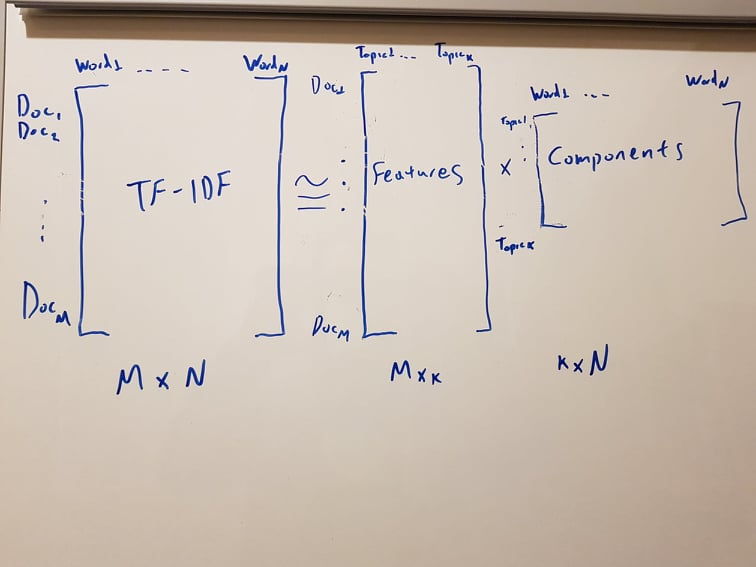




In [1]:
from datetime import datetime
import pandas as pd
import numpy as np
import json
import re
import string
import nltk

In [2]:
df = pd.read_csv("timeseries_data.csv")
df.head()

,Unnamed: 0,filingDate,reportingDate,financialEntity,coDescription,CIK,coDescription_lemmatized,coDescription_stopwords,reports
0,0,2017-06-29 20:05:22 UTC,2017-04-01,financialEntities/params;cik=1164888,m2.properties 4 item3.legalproceedings 4 ite...,1164888,m2.properties 4 item3.legalproceedings 4 item4...,disclosure part iiitem marketfor registrant co...,3
1,1,2016-03-03 17:53:54 UTC,2016-02-01,financialEntities/params;cik=1637459,l kraft heinz is one of the largest food and b...,1637459,l kraft heinz is one of the largest food and b...,l kraft heinz one largest food beverage compan...,3
2,2,2018-05-25 01:55:42 UTC,2018-04-01,financialEntities/params;cik=1302215,"established in 1972, houlihan lokey, inc., is ...",1302215,"established in 1972 , houlihan lokey , inc. , ...",established houlihan lokey leading global inde...,3
3,3,2018-12-19 22:01:54 UTC,2018-10-01,financialEntities/params;cik=725363,solved seccomments none item2.properties cel-s...,725363,solved seccomments none item2.properties cel-s...,solved seccomments none office space boone blv...,3
4,4,2018-02-28 18:47:50 UTC,2018-01-01,financialEntities/params;cik=103379,"orporation, organized in 1899, is a global lea...",103379,"orporation , organized in 1899 , is a global l...",orporation organized global leader design prod...,3


In [21]:
filtered = df[df["reports"] > 2].sort_values(["CIK","filingDate"])
filtered

,Unnamed: 0,filingDate,reportingDate,financialEntity,coDescription,CIK,coDescription_lemmatized,coDescription_stopwords,reports
1948,1948,2016-12-06 22:05:12 UTC,2016-10-01,financialEntities/params;cik=3545,"alico, inc. (“alico”), was incorporated under ...",3545,"alico , inc. ( “ alico ” ) , wa incorporated u...",alico alico wa incorporated law state florida ...,3
1456,1456,2017-12-11 22:13:06 UTC,2017-10-01,financialEntities/params;cik=3545,"alico, inc. (“alico”) was incorporated under t...",3545,"alico , inc. ( “ alico ” ) wa incorporated und...",alico alico wa incorporated law state florida ...,3
83,83,2018-12-06 21:58:38 UTC,2018-10-01,financialEntities/params;cik=3545,"alico, inc. (“alico”) was incorporated under t...",3545,"alico , inc. ( “ alico ” ) wa incorporated und...",alico alico wa incorporated law state florida ...,3
832,832,2016-05-25 20:19:47 UTC,2016-04-01,financialEntities/params;cik=4457,we are north america’s largest “do-it-yourself...,4457,we are north america ’ s largest “ do-it-yours...,north america largest moving storage operator ...,3
1242,1242,2017-05-24 20:07:02 UTC,2017-04-01,financialEntities/params;cik=4457,we are north america’s largest “do-it-yourself...,4457,we are north america ’ s largest “ do-it-yours...,north america largest moving storage operator ...,3
...,...,...,...,...,...,...,...,...,...
1531,1531,2017-11-29 02:25:15 UTC,2017-10-01,financialEntities/params;cik=1666138,llowing discussion of our business contains fo...,1666138,llowing discussion of our business contains fo...,llowing discussion business contains statement...,3
481,481,2018-11-28 01:38:36 UTC,2018-10-01,financialEntities/params;cik=1666138,llowing discussion of our business contains fo...,1666138,llowing discussion of our business contains fo...,llowing discussion business contains statement...,3
963,963,2016-12-19 14:14:40 UTC,2016-10-01,financialEntities/params;cik=1674910,generalvalvoline inc. is a kentucky corporatio...,1674910,generalvalvoline inc. is a kentucky corporatio...,generalvalvoline kentucky corporation principa...,3
1760,1760,2017-11-17 17:10:16 UTC,2017-10-01,financialEntities/params;cik=1674910,"generalvalvoline inc., a kentucky corporation,...",1674910,"generalvalvoline inc. , a kentucky corporation...",generalvalvoline kentucky corporation worldwid...,3


In [4]:
data = filtered.loc[:,"coDescription_stopwords"].to_list()
dates = filtered["filingDate"].to_list()

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

def get_topics(components, feature_names, n=50):
    for idx, topic in enumerate(components):
        print("\nTopic %d: " % (idx+1), [(feature_names[i], topic[i].round(2)) for i in topic.argsort()[:-n - 1:-1]])
        
vectorizer = TfidfVectorizer(max_features=2000) 
X = vectorizer.fit_transform(data)

nmf_model = NMF(n_components=20, init='nndsvd', random_state=0)
nmf_top = nmf_model.fit_transform(X)

terms = vectorizer.get_feature_names() 
get_topics(nmf_model.components_,terms)


Topic 1:  [('business', 1.48), ('may', 1.27), ('could', 0.81), ('result', 0.59), ('operation', 0.47), ('financial', 0.45), ('target', 0.4), ('adversely', 0.39), ('future', 0.37), ('transaction', 0.37), ('combination', 0.35), ('opportunity', 0.33), ('acquisition', 0.32), ('change', 0.31), ('potential', 0.31), ('law', 0.3), ('merger', 0.3), ('cost', 0.3), ('affect', 0.3), ('market', 0.29), ('risk', 0.29), ('regulation', 0.28), ('including', 0.28), ('condition', 0.28), ('management', 0.28), ('ability', 0.27), ('subject', 0.26), ('security', 0.26), ('state', 0.26), ('time', 0.26), ('statement', 0.25), ('factor', 0.24), ('entity', 0.24), ('new', 0.23), ('shareholder', 0.23), ('venture', 0.23), ('act', 0.23), ('requirement', 0.23), ('plan', 0.22), ('would', 0.22), ('public', 0.22), ('significant', 0.22), ('adverse', 0.22), ('growth', 0.21), ('unable', 0.21), ('additional', 0.21), ('capital', 0.21), ('effect', 0.21), ('certain', 0.2), ('event', 0.2)]

Topic 2:  [('share', 1.25), ('stock', 1.

C:\Users\maryx\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\maryx\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


### Get the Topic of a Document

In [23]:
my_document = data[0]
my_document

'alico alico wa incorporated law state florida collectively subsidiary company u business operation described detailed financial information respect business operation see management discussion analysis financial condition result operation included item annual report form accompanying consolidated combined financial statement related note therein included item addition general information concerning company found website internet address http filing sec including limited annual report form quarterly report form current report form amendment thereto available free charge website soon reasonably practicable material electronically filed furnished sec addition may read copy material file sec sec public reference room f street ne washington dc obtain information operation public reference room may call sec recent press release information regarding corporate governance including charter audit compensation executive nominating governance committee well code business conduct ethic also avail

In [36]:
#Look at the Features matrix and get the 0th row
print(pd.DataFrame(nmf_top).loc[0])
# The result is the probability of each topic representing the document, we can get the one with the max val
# row 16 has the highest score so this document was classified as Topic 17

0     0.003703
1     0.001019
2     0.005247
3     0.000000
4     0.000000
5     0.000000
6     0.000000
7     0.001007
8     0.000000
9     0.000000
10    0.000000
11    0.000000
12    0.001433
13    0.002875
14    0.001104
15    0.226474
16    0.024883
17    0.006127
18    0.000000
19    0.000000
Name: 0, dtype: float64


### Predict Topic of a Document

In [33]:
new_description = pd.read_csv("preprocessed.csv", index_col=0)["coDescription_stopwords"][0]
new_description 

'mongodb leading modern general purpose database platform robust platform enables developer build modernize application rapidly across broad range use case organization deploy platform scale cloud hybrid environment unique database architecture able address need organization performance scalability flexibility reliability maintaining strength legacy database business model combine developer mindshare adoption benefit open source economic benefit proprietary software subscription business application redefining organization across industry engage customer operate business compete compete effectively today global market environment organization must provide application capture leverage vast volume variety available data result software developer build maintain application increasingly influential organization demand talent ha grown substantially consequently organization significantly increased investment developer productivity ha become strategic imperative organization size industry ge

In [39]:
X = vectorizer.transform([new_description])
nmf_top = nmf_model.transform(X)
pd.DataFrame(nmf_top)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.003703,0.001019,0.005247,0.0,0.0,0.0,0.0,0.001007,0.0,0.0,0.0,0.0,0.001433,0.002875,0.001104,0.226474,0.024883,0.006127,0.0,0.0


In [35]:
pd.DataFrame(nmf_top).idxmax(axis=1)
## Topic 16

0    15
dtype: int64

NameError: name 'vectorizer' is not defined